# Firearm Homiciede Analysis

In [16]:
#Import all necesary packages and functions for this analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
from scipy.stats import iqr
import math
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from statsmodels.api import qqplot
import scipy.stats as stats


In [17]:
#Import Data - the original data file can be found here: https://content.cityhealthdashboard.com/drupal/media/23/download
city_dat = pd.read_csv('C:/Users/16186/OneDrive - Johns Hopkins/Python/FinalProject/city_health_dat.csv',
                 dtype = {'state_abbr': str, 'geo_name': str, 'metric_name': str, 'group_name': str, 'est': float},
                 usecols = ['state_abbr', 'geo_name', 'metric_name', 'group_name','est'])

#Pivot data to put metrics in columns
city_dat = pd.DataFrame(city_dat[city_dat['group_name'] == 'Total'].pivot_table(index=['state_abbr', 'geo_name'], columns = 'metric_name', values = 'est'))

#We're going to regress on Firearm Homicide, so we need to remove NAs from that column.
city_dat.dropna(subset='Firearm Homicides', inplace = True)

city_dat = city_dat.reset_index()

#Take a look at the data
city_dat

metric_name,state_abbr,geo_name,Absenteeism,Air Pollution - Ozone,Air Pollution - Particulate Matter,Binge Drinking,Breast Cancer Deaths,Broadband Connection,Cardiovascular Disease Deaths,Children in Poverty,...,Racial/Ethnic Diversity,Rent Burden,"Routine Checkup, 18+",Smoking,Teen Births,Third-Grade Reading Scores,"Unemployment - Annual, Neighborhood-Level","Unemployment - Current, City-Level",Uninsured,Walkability
0,AK,Anchorage,27.1,NaN,NaN,21.4,20.6,76.8,144.8,11.1,...,78.2,46.7,62.1,16.4,15.5,NaN,5.4,3.333333,11.8,31.0
1,AL,Auburn,5.7,37.216667,9.133333,18.3,45.6,78.7,179.9,15.9,...,61.4,59.3,73.9,14.7,NaN,4.5,2.8,2.391667,6.0,23.5
2,AL,Birmingham,35.2,39.816667,10.966667,12.4,38.5,58.8,343.6,40.7,...,61.7,53.1,79.9,19.5,43.9,0.6,8.0,3.375000,15.1,32.7
3,AL,Decatur,18.5,39.675000,10.366667,14.6,26.9,63.4,277.2,23.0,...,61.2,43.3,76.2,21.7,NaN,2.0,5.8,2.250000,13.7,23.9
4,AL,Dothan,18.7,36.958333,10.475000,13.2,19.2,65.9,198.0,28.7,...,55.5,44.5,78.1,20.8,NaN,2.5,5.4,2.725000,13.1,21.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456,WI,Milwaukee,59.7,37.175000,10.091667,24.0,23.3,65.3,248.4,33.4,...,81.9,51.4,74.6,21.8,30.1,NaN,6.2,4.200000,10.3,54.9
457,WI,Racine,38.5,39.708333,11.783333,23.2,28.9,68.7,248.7,27.0,...,71.2,54.3,75.2,22.2,NaN,0.8,5.8,4.366667,8.0,24.9
458,WI,West Allis,29.9,36.691667,10.583333,26.7,27.2,69.9,248.8,12.7,...,58.6,42.4,72.9,17.9,NaN,2.6,4.2,3.375000,7.3,62.0
459,WV,Charleston,20.0,36.991667,7.725000,10.8,20.7,69.4,219.5,23.4,...,42.1,48.0,84.6,21.3,NaN,2.8,6.3,3.533333,6.2,16.4


## Assess Potential Independent Variables

In [18]:
#Look at correlations in the data
correlation = city_dat.drop(['state_abbr','geo_name'],axis=1).corr()

correlation = pd.DataFrame(correlation['Firearm Homicides'].sort_values(ascending=False)).reset_index()
correlation['Firearm Homicides'] = correlation['Firearm Homicides'].round(2)
correlation = correlation.rename(columns = {'metric_name': 'Metric Name'})

#Subset Correlation Table So that Firearm Homicides is not included. Furthermore, add constrains for correlations to explore.
#Remove variables where clear multicollinearity would exist
#Generate a Plot with Subsetted information
correlation_table_sub = correlation[(correlation['Firearm Homicides'] >= 0.45) | (correlation['Firearm Homicides'] <= -0.45)]
correlation_table_sub = correlation_table_sub[(correlation_table_sub['Metric Name'] != 'Firearm Homicides') & 
                                              (correlation_table_sub['Metric Name'] != 'Premature Deaths (All Causes)') &
                                              (correlation_table_sub['Metric Name'] != 'Life Expectancy')]

#Take a look at the table
correlation_table_sub


,Metric Name,Firearm Homicides
1,Low Birthweight,0.73
3,Neighborhood Racial/Ethnic Segregation,0.61
4,Children in Poverty,0.59
5,Diabetes,0.58
6,High Blood Pressure,0.57
7,Credit Insecurity Index,0.54
8,Teen Births,0.52
9,Obesity,0.49
10,Smoking,0.47
11,"Unemployment - Annual, Neighborhood-Level",0.47


## Subset Data for Variables of Interest for Regression Modeling

In [19]:
#Subset dataframe for columns of interest and analyze further
reg_vars = ['state_abbr','geo_name', 'Firearm Homicides', 'Low Birthweight', 'Neighborhood Racial/Ethnic Segregation', 'Children in Poverty',
           'Diabetes', 'High Blood Pressure', 'Credit Insecurity Index', 'Teen Births', 'Obesity', 'Smoking', 'Unemployment - Annual, Neighborhood-Level',
           'Physical Inactivity', 'Income Inequality', 'Broadband Connection','Frequent Mental Distress', 'Opioid Overdose Deaths']

#Subset dataframe for only cols of interest and assign to new object
reg_data = city_dat[reg_vars]

#Get Summary Statistics
reg_data.describe().round(2)

#Remove variables with many NAs
reg_data = reg_data.drop(columns = ['Low Birthweight', 'Teen Births', 'High Blood Pressure'], axis = 1)

#Get final Summary Statistics
reg_data.describe().round(2)


metric_name,Firearm Homicides,Neighborhood Racial/Ethnic Segregation,Children in Poverty,Diabetes,Credit Insecurity Index,Obesity,Smoking,"Unemployment - Annual, Neighborhood-Level",Physical Inactivity,Income Inequality,Broadband Connection,Frequent Mental Distress,Opioid Overdose Deaths
count,461.00,461.00,461.00,461.00,461.00,461.00,461.00,461.00,461.00,461.00,461.00,461.00,441.00
mean,7.77,13.73,21.61,10.89,23.63,33.84,17.22,6.40,25.53,-10.70,72.36,15.92,21.83
std,6.93,6.50,9.38,2.36,8.30,5.41,4.02,2.13,5.17,14.98,7.87,1.76,18.87
min,0.90,4.20,2.10,6.00,7.00,19.20,7.80,2.20,12.60,-46.60,38.90,11.00,2.80
25%,3.40,9.00,14.80,9.20,17.70,30.00,14.30,5.00,21.70,-21.60,67.50,14.80,8.70
50%,5.60,12.50,21.40,10.80,23.10,34.20,17.20,6.00,25.60,-12.80,73.10,16.00,14.60
75%,9.70,16.90,27.40,12.20,28.40,37.60,20.00,7.40,29.00,-1.30,78.00,17.10,28.70
max,49.60,41.90,54.80,22.50,52.40,51.60,30.20,18.60,42.80,42.40,89.60,21.00,112.10


## Visualize Relationships to Firearm Homicides

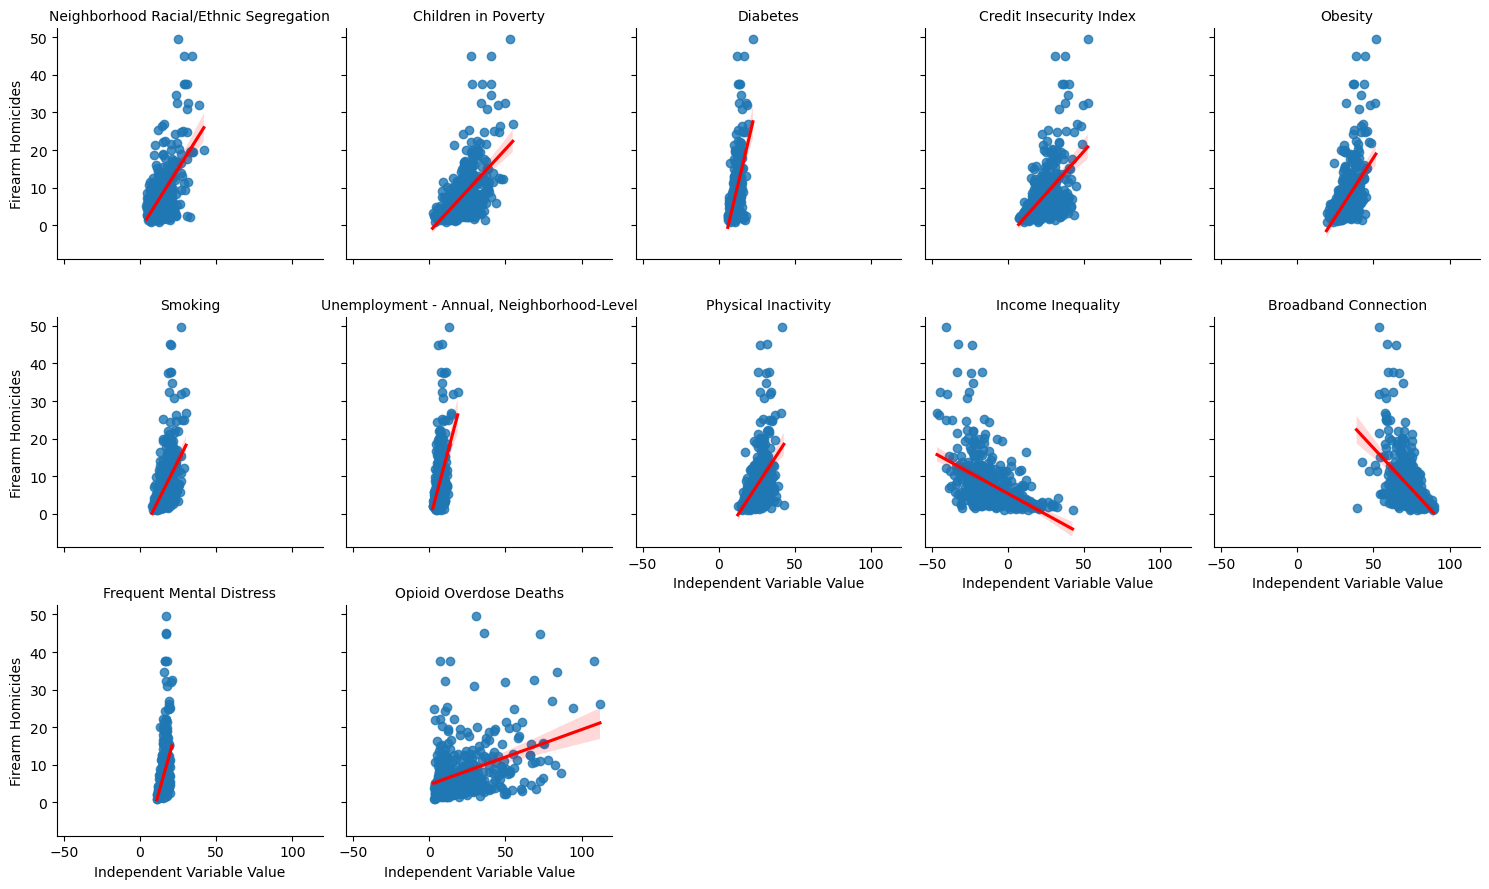

In [5]:
#Visualize what this looks like
reg_data_long = reg_data.melt(id_vars = ['state_abbr','geo_name'])

#Sep for dependent and inependent vars
reg_plt_y = reg_data_long[reg_data_long['metric_name'] == 'Firearm Homicides']
reg_plt_x = reg_data_long[reg_data_long['metric_name'] != 'Firearm Homicides']

#Merge them back together
reg_plt = pd.merge(reg_plt_x, reg_plt_y, on = ['state_abbr','geo_name'])
reg_plt_merged = reg_plt.rename(columns = {'value_y': 'Firearm Homicides', 'value_x': 'Independent Variable Value'})

#Plot the results
reg_plt = sns.FacetGrid(data = reg_plt_merged, col = 'metric_name_x', col_wrap = 5)
reg_plt.map(sns.regplot, 'Independent Variable Value', 'Firearm Homicides', line_kws = {'color': 'red'})
reg_plt.set_titles(col_template="{col_name}")



## Visualize Firearm Homicides

Text(0.5, 1.0, 'Firearm Homicide Distribution')

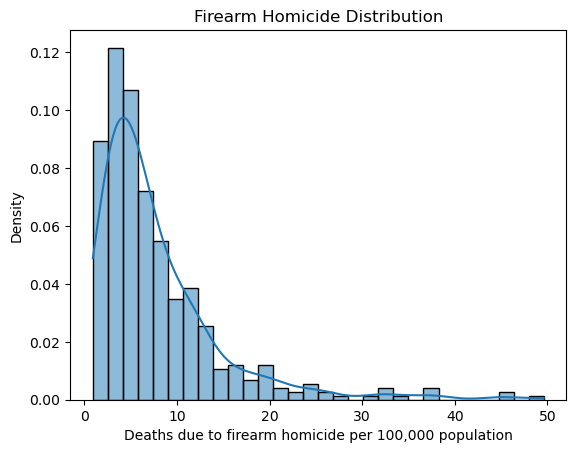

In [6]:
#Create historgram for firearm homicide
g = sns.histplot(data = reg_data, x = reg_data['Firearm Homicides'], kde = True, stat = 'density')
g.set(xlabel = 'Deaths due to firearm homicide per 100,000 population')
g.set_title('Firearm Homicide Distribution')


## Structure Data for Regression Analysis and Evaluate VIF Scores

In [7]:
#Finally, do the actual regression
reg_data.rename(columns = {'Firearm Homicides': 'firearm_homicides',
                         'Neighborhood Racial/Ethnic Segregation': 'segregation',
                         'Children in Poverty': 'childhood_poverty',
                         'Cardiovascular Disease Deaths': 'cardio_deaths',
                         'Absenteeism': 'absenteeism',
                         'Diabetes':'diabetes',
                         'Opioid Overdose Deaths': 'opiod_overdose',
                         'Credit Insecurity Index': 'credit_insecurity',
                         'Colorectal Cancer Deaths': 'colorectal_cancer',
                         'Physical Inactivity': 'physical_inactivity',
                         'Smoking':'smoking',
                         'Frequent Physical Distress': 'physical_distress',
                         'Obesity': 'obesity',
                         'Unemployment - Annual, Neighborhood-Level': 'unemployment',
                         'Income Inequality': 'income_inequality',
                         'Broadband Connection': 'broadband',
                         'Frequent Mental Distress': 'mental_distress',
                         'Opioid Overdose Deaths': 'opiod_overdose'}, inplace = True
                        )

#Check for issues in VIF for multicollinearity risk

#Add constant to df
reg_data = sm.add_constant(reg_data)

#Impute few missing NA values for opiod overdose with simple median
reg_data['opiod_overdose'][pd.isna(reg_data['opiod_overdose'])] = reg_data['opiod_overdose'].median()


#Calculate VIFS and prune VIFS > 5
vif_list = ['const', 'segregation', 'credit_insecurity', 'obesity', 'smoking', 'unemployment', 'physical_inactivity', 
            'income_inequality', 'broadband','mental_distress','opiod_overdose']

vif = pd.DataFrame()
vif['variable'] = vif_list

vif['VIF'] = [variance_inflation_factor(reg_data[vif_list].values, i) for i in range(len(vif_list))]
        
#Evaluate Final VIF Table    
vif.round(2)


C:\Users\16186\AppData\Local\Temp\ipykernel_40152\2150807528.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reg_data['opiod_overdose'][pd.isna(reg_data['opiod_overdose'])] = reg_data['opiod_overdose'].median()


,variable,VIF
0,const,643.85
1,segregation,1.44
2,credit_insecurity,2.98
3,obesity,2.84
4,smoking,4.22
5,unemployment,1.65
6,physical_inactivity,3.46
7,income_inequality,5.92
8,broadband,3.52
9,mental_distress,2.47


## Regression Test with All Variables

In [8]:
#Build Model - it appears that there are major problems
ols_model_1 = smf.ols('firearm_homicides ~  segregation +  credit_insecurity +  obesity + smoking + unemployment + physical_inactivity + broadband + mental_distress + opiod_overdose', data = reg_data).fit(cov_type='HC1')
print(ols_model_1.summary())

                            OLS Regression Results                            
Dep. Variable:      firearm_homicides   R-squared:                       0.561
Model:                            OLS   Adj. R-squared:                  0.553
Method:                 Least Squares   F-statistic:                     34.45
Date:                Sun, 13 Aug 2023   Prob (F-statistic):           3.85e-46
Time:                        13:47:19   Log-Likelihood:                -1355.8
No. Observations:                 461   AIC:                             2732.
Df Residuals:                     451   BIC:                             2773.
Df Model:                           9                                         
Covariance Type:                  HC1                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -7.2700    

## Regression Test After Removing Statistically Insignificant Variables (>5%)

In [9]:
#Build Model - remove statistically insignificant coefficients
ols_model_2 = smf.ols('firearm_homicides ~  segregation +  obesity + unemployment + opiod_overdose', data = reg_data).fit(cov_type='HC1')
print(ols_model_2.summary())

                            OLS Regression Results                            
Dep. Variable:      firearm_homicides   R-squared:                       0.552
Model:                            OLS   Adj. R-squared:                  0.548
Method:                 Least Squares   F-statistic:                     52.88
Date:                Sun, 13 Aug 2023   Prob (F-statistic):           1.35e-36
Time:                        13:47:19   Log-Likelihood:                -1360.8
No. Observations:                 461   AIC:                             2732.
Df Residuals:                     456   BIC:                             2752.
Df Model:                           4                                         
Covariance Type:                  HC1                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        -14.7209      1.822     -8.

## Visualize Residual Outputs to Assess Normality

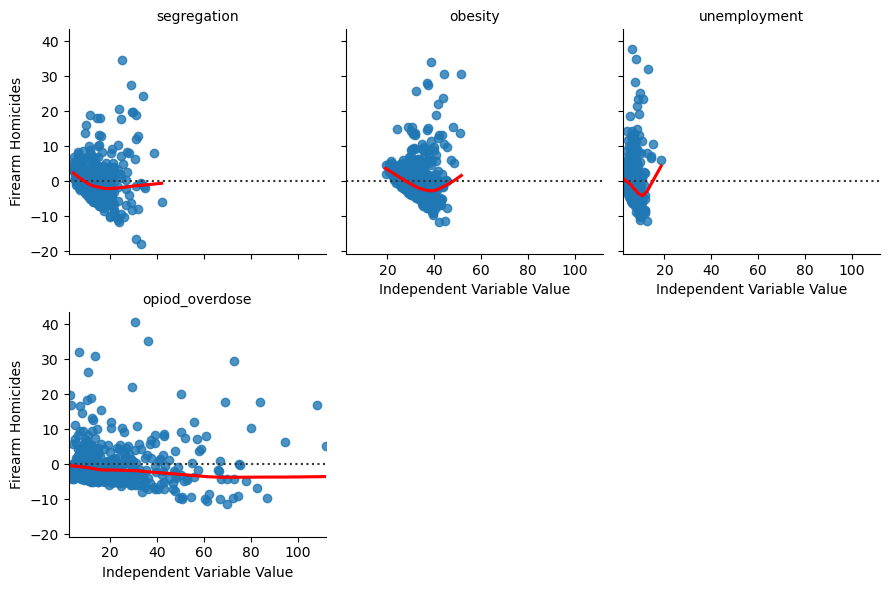

In [10]:
#Visualize residuals to better understand issues with the model
reg_data_long_residual = reg_data[['state_abbr', 'geo_name', 'firearm_homicides', 'segregation',
                                  'obesity', 'unemployment',  'opiod_overdose']].melt(id_vars = ['state_abbr','geo_name'])

#reg_data_long_residual = reg_data_long_residual.pivot(columns='variable', values = 'value')

reg_resid_plt_y = reg_data_long_residual[reg_data_long_residual['variable'] == 'firearm_homicides']
reg_resid_plt_x = reg_data_long_residual[reg_data_long_residual['variable'] != 'firearm_homicides']

#Merge them back together
reg_resid_plt_merged = pd.merge(reg_resid_plt_x, reg_resid_plt_y, on = ['state_abbr','geo_name'])
reg_resid_plt_merged = reg_resid_plt_merged.rename(columns = {'value_y': 'Firearm Homicides', 'value_x': 'Independent Variable Value'})

#Build Plots
reg_resid_plt = sns.FacetGrid(data = reg_resid_plt_merged, col = 'variable_x', col_wrap = 3)
reg_resid_plt.map(sns.residplot, 'Independent Variable Value', 'Firearm Homicides', lowess=True, line_kws=dict(color='r'))
reg_resid_plt.set_titles(col_template="{col_name}")


## Perform Transformation to Enhance Normality of Residuals

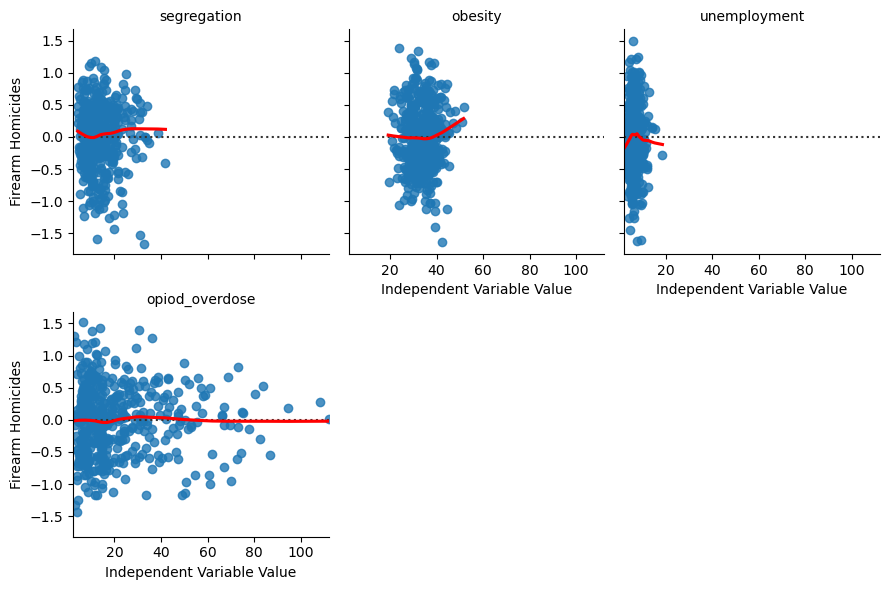

In [11]:
#Do Box Cox transformation to standardize residuals. All appear to be somewhat heteroskedastic
transformed_data, best_lambda = stats.boxcox(reg_data['firearm_homicides'])

reg_data['firearm_homicides_box_cox'] = transformed_data


#Visualize transformation by manipulating data
reg_data_long_residual = reg_data[['firearm_homicides_box_cox','state_abbr', 'geo_name', 'segregation', 'obesity', 
                                   'unemployment', 'opiod_overdose']].melt(id_vars = ['state_abbr','geo_name'])


#Sep for dependent and inependent vars
reg_resid_plt_y = reg_data_long_residual[reg_data_long_residual['variable'] == 'firearm_homicides_box_cox']
reg_resid_plt_x = reg_data_long_residual[reg_data_long_residual['variable'] != 'firearm_homicides_box_cox']

#Merge them back together
reg_resid_plt_merged = pd.merge(reg_resid_plt_x, reg_resid_plt_y, on = ['state_abbr','geo_name'])

reg_resid_plt_merged = reg_resid_plt_merged.rename(columns = {'value_y': 'Firearm Homicides', 'value_x': 'Independent Variable Value'})

#Plot the result
reg_resid_plt = sns.FacetGrid(data = reg_resid_plt_merged, col = 'variable_x', col_wrap = 3)
reg_resid_plt.map(sns.residplot, 'Independent Variable Value', 'Firearm Homicides', lowess=True, line_kws=dict(color='r'))
reg_resid_plt.set_titles(col_template="{col_name}")


## Build Final Regression Model with Transformed Dependent Variable and Significant Variables

In [15]:
#Build Model  -remove coefficients that don't have a sizeable impact on the model's R2 value or are statstically insignificant
ols_model_2 = smf.ols('firearm_homicides_box_cox ~ segregation  + obesity  + unemployment', data = reg_data).fit(cov_type='HC1')
print(ols_model_2.summary())

                                OLS Regression Results                               
Dep. Variable:     firearm_homicides_box_cox   R-squared:                       0.486
Model:                                   OLS   Adj. R-squared:                  0.482
Method:                        Least Squares   F-statistic:                     143.9
Date:                       Sun, 13 Aug 2023   Prob (F-statistic):           1.18e-65
Time:                               13:47:21   Log-Likelihood:                -251.29
No. Observations:                        461   AIC:                             510.6
Df Residuals:                            457   BIC:                             527.1
Df Model:                                  3                                         
Covariance Type:                         HC1                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------

## Visualize Normality

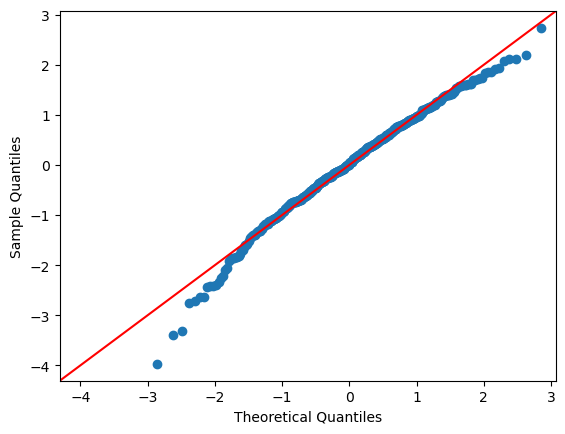

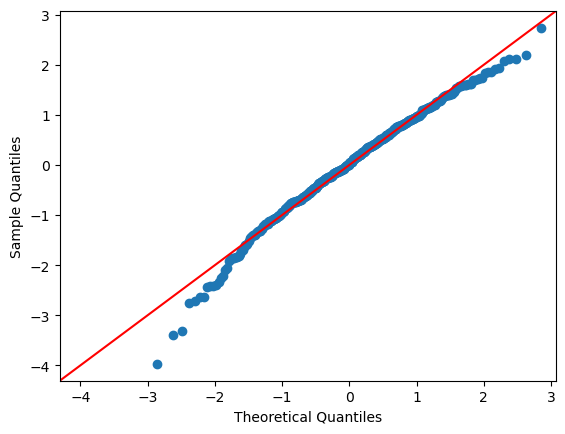

In [14]:
#Check normlity
qqplot(data = ols_model_2.resid, fit=True, line ='45')